In [1]:
import jax.numpy as np
import numpy as onp
from jax import grad, jit, vmap, jacfwd, jacrev
from jax import random
from jax.ops import index_update
import matplotlib.pyplot as plt

import astropy.io.fits as pf
import xaosim as xs
from xaosim.pupil import HST_NIC1 as HST
from scipy.ndimage import rotate

from time import time as clock
from tqdm import tqdm_notebook as tqdm
import morphine

%matplotlib inline

import matplotlib as mpl
mpl.style.use('seaborn-colorblind')
phasemap = mpl.cm.rainbow
phasemap.set_bad(color='k')


#To make sure we have always the same matplotlib settings
#(the ones in comments are the ipython notebook settings)

mpl.rcParams['figure.figsize']=(12.0,9.0)    #(6.0,4.0)
mpl.rcParams['font.size']=20               #10 
mpl.rcParams['savefig.dpi']= 200             #72 
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['axes.labelsize'] = 18
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
from matplotlib import rc
mpl.rcParams["font.family"] = "Times New Roman"

colours = mpl.rcParams['axes.prop_cycle'].by_key()['color']

from astropy import units as units

import warnings
warnings.filterwarnings("ignore")


/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/locations.py:346: UserWarning: Extinction files not found in /Users/benjaminpope/pysynphot/grp/hst/cdbs/extinction
  warnings.warn('Extinction files not found in %s' % (extdir, ))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:118: UserWarning: No graph or component tables found; functionality will be SEVERELY crippled. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmg.fits
  'functionality will be SEVERELY crippled. ' + str(e))
/Users/benjaminpope/opt/anaconda3/lib/python3.7/site-packages/pysynphot/refs.py:125: UserWarning: No thermal tables found, no thermal calculations can be performed. No files found for /Users/benjaminpope/pysynphot/grp/hst/cdbs/mtab/*_tmt.fits
  'no thermal calculations can be performed. ' + str(e))


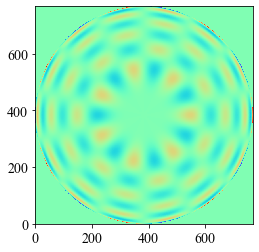

In [2]:
NZ = 200
PPSZ = 256
PSZ = PPSZ*3

zernikes = morphine.zernike.zernike_basis(NZ,npix=PSZ,outside=0.0)
plt.imshow(zernikes[-3,:,:],cmap=phasemap)


In [3]:
coefficients = onp.random.randn(NZ)

In [4]:
def make_mode(coeff):
    return np.dot(coeff,zernikes.reshape(NZ,PSZ*PSZ)).reshape(PSZ,PSZ)

In [5]:
mode = make_mode(coefficients)

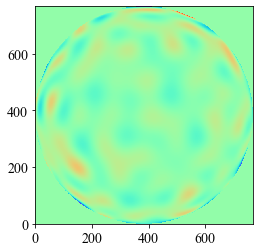

In [6]:
plt.imshow(mode,cmap=phasemap)

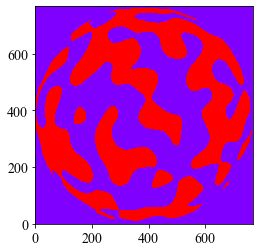

In [7]:
plt.imshow(mode>0,cmap=phasemap)

In [8]:
x0, y0 = 0.3, 0.6

npix = 50
xx, yy = np.meshgrid(np.linspace(0,1,npix),np.linspace(0,1,npix))
rr = np.sqrt((xx-x0)**2 + (yy-y0) **2) 

vignette = np.exp(-(rr/0.25)**3)
vignette /= np.max(vignette)
vignette = 30*xx+5*yy -12

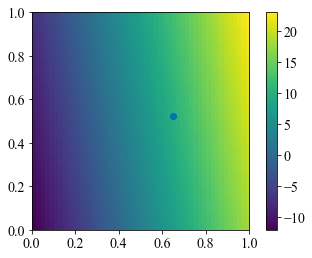

In [9]:
@jit
def normalize(vignette):
    return (vignette-np.min(vignette))/(np.max(vignette)-np.min(vignette))

@jit
def centroid(vignette):
    vv = normalize(vignette)
    xx, yy = np.meshgrid(np.linspace(0,1,vignette.shape[0]),np.linspace(0,1,vignette.shape[1]))
    return np.sum(vv*xx)/np.sum(vv),np.sum(vv*yy)/np.sum(vv)

plt.imshow(vignette,extent=[0,1,0,1])
plt.colorbar()
plt.scatter(centroid(vignette)[0],centroid(vignette)[1])

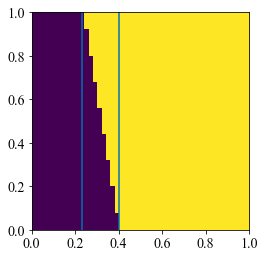

In [10]:
plt.imshow((vignette)>0,extent=[0,1,0,1])
plt.axvline(0.233)
plt.axvline(0.39999917)

In [11]:
def lsq_params(img):
    xx, yy = np.meshgrid(np.linspace(0,1,img.shape[0]),np.linspace(0,1,img.shape[1]))
    A = np.vstack([xx.ravel(), yy.ravel(), np.ones_like(xx).ravel()]).T
    matrix = np.linalg.inv(np.dot(A.T,A)).dot(A.T)
    return matrix, xx, yy, A

@jit
def lsq(img):
    return np.dot(matrix,img.ravel())

def area(img):
    #line of nodes: ax + by + c = 0
    # y = -c/b -(a/b)x
    # indefinite integral is (-c/b)x -(a/2b)x**2
    # so area under curve from 0 to 1 is (-c/b -a/2b)
    # but at y = 1: ax + b + c = 0
    # x_1 = (-b-c)/a
    # at y = 0: ax + c = 0 -> x_2 = -c/a
    if np.all(img>0):
        return 1.
    elif np.all(img<0):
        return 0.
    else:
        a,b,c = lsq(img)
        
        x1 = (-b-c)/a
        x2 = -c/a
        x1, x2 = np.min([x1,x2]), np.max([x1,x2])
        x1, x2 = np.max([x1,0]), np.min([x2,1])

        dummy = x1 + (-c/b)*x2-(0.5*a/b)*x2**2 - (-c/b)*x1+(0.5*a/b)*x1**2
        positive = np.mean(img)>0 # 1 if positive, 0 if negative
        if dummy > 0.5:
            dummy = 1-dummy
        if positive:
            return (1-dummy)
        else:
            return dummy
        
@jit
def jit_area(img):
    #line of nodes: ax + by + c = 0
    # y = -c/b -(a/b)x
    # indefinite integral is (-c/b)x -(a/2b)x**2
    # so area under curve from 0 to 1 is (-c/b -a/2b)
    # but at y = 1: ax + b + c = 0
    # x_1 = (-b-c)/a
    # at y = 0: ax + c = 0 -> x_2 = -c/a
#     binary = np.where(np.all((img<0))+np.all((img>0)),1,0)
#     if np.all(img>0):
#         return 1.
#     elif np.all(img<0):
#         return 0.
#     else:
    a,b,c = lsq(img)
    a, b, c = np.where(a==0,1e-15,a), np.where(b==0,1e-15,b), np.where(c==0,1e-15,c)
    x1 = (-b-c)/(a) # don't divide by zero
    x2 = -c/(a) # don't divide by zero
    x1, x2 = np.min([x1,x2]), np.max([x1,x2])
    x1, x2 = np.max([x1,0]), np.min([x2,1])

    dummy = x1 + (-c/b)*x2-(0.5*a/b)*x2**2 - (-c/b)*x1+(0.5*a/b)*x1**2
    positive = np.mean(img)>0 # 1 if positive, 0 if negative
    dummy = np.where(dummy>=0.5,dummy,1-dummy)
    dummy = np.where(np.mean(img)>=0,dummy,1-dummy)
    dummy = np.where(np.all(img>0),1,dummy)
    dummy = np.where(np.all(img<=0),0,dummy)
    dummy = np.where(np.any(img==0),np.mean(dummy>0),dummy)
    dummy = np.where(np.all(img==0),0,dummy)

    dummy = np.where(dummy>1,1,dummy)
    dummy = np.where(dummy<0,0,dummy) # godawful hacks, jesus christ
    return dummy

In [12]:
matrix, xx, yy, A = lsq_params(vignette)

a, b, c = lsq((vignette))
print(a,b,c)

29.999971 4.999959 -11.999964


In [13]:
%%timeit
lsq(vignette)

87.2 µs ± 8.38 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [14]:
%%timeit
jit_area(vignette)

103 µs ± 28.4 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


-23.333332 12.222225


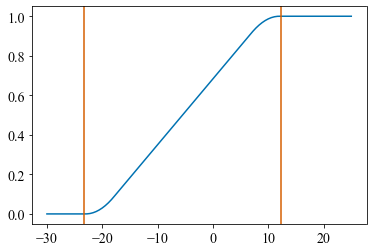

In [15]:
down = np.linspace(-30,25,100)
thresh = []
cxx, cyy = [],[]
for d in down:
    thresh.append(jit_area(vignette+d))
    cen = centroid(vignette+d)
    cxx.append(cen[0])
    cyy.append(cen[1])
thresh = np.array(thresh)
plt.plot(down,thresh)
lower, upper = np.max(np.where(thresh==0)), np.min(np.where(thresh==1))
print(down[lower],down[upper])
plt.axvline(down[lower],color=colours[2])
plt.axvline(down[upper],color=colours[2])

In [16]:
test = np.array(mode.split(PPSZ))
test = np.array(test.split(PPSZ,axis=2))


In [17]:
%%time
# def soft_thresh(array):
dummy = np.array(mode.split(PPSZ))
dummy = np.array(dummy.split(PPSZ,axis=2))

output = np.zeros((PPSZ,PPSZ))
subarray = dummy[0,0,:,:]
matrix, xx, yy, A = lsq_params(subarray)


CPU times: user 202 ms, sys: 26.3 ms, total: 228 ms
Wall time: 187 ms


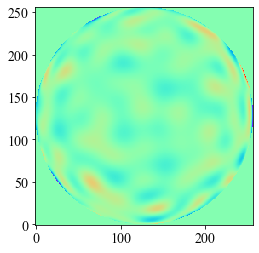

In [18]:
plt.imshow(dummy[:,:,0,0],cmap=phasemap)


In [19]:
flat = dummy.reshape(PPSZ*PPSZ,3,3)

In [20]:
vmap_mask = (vmap(jit_area,in_axes=(0)))
masked = vmap_mask(flat)

In [21]:
print('Too low:',np.sum(masked<0),'; Too High: ',np.sum(masked>1))

Too low: 0 ; Too High:  0


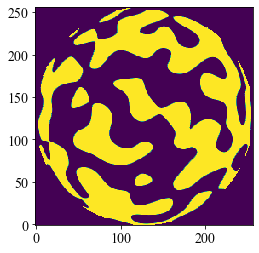

In [22]:
plt.imshow(vmap_mask(flat).reshape(PPSZ,PPSZ),vmin=0,vmax=1)

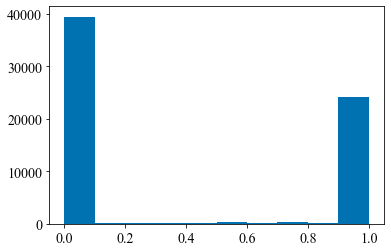

In [23]:
plt.hist(vmap_mask(flat).flatten());

In [24]:
%%timeit 
vmap_mask(flat)

977 µs ± 12.4 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


### Now we can do soft edges, let's think about optimizing things!

In [25]:
pdiam = 1
ISZ = 128
PIXSCALE = 0.025
WAVELENGTH = 1.0e-6
ppscale = pdiam/PPSZ

def psf_from_zernikes(coefficients_sequence):

    toliman_new = morphine.CircularAperture(radius=pdiam/2)
    toliman_new.pupil_diam = pdiam

    aberrated = morphine.OpticalSystem(npix=PSZ)
    aberrated.add_pupil(toliman_new)    # pupil radius in meters
    aberrated.pupil_diameter = pdiam
    wf = aberrated.input_wavefront()

    thinlens = morphine.ZernikeWFE(radius=pdiam/2., coefficients=coefficients_sequence, cached_zernikes=zernikes)
    aberrated.add_pupil(thinlens)
    aberrated.add_detector( pixelscale=PIXSCALE*2, fov_arcsec=2.*ISZ*PIXSCALE )

    blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')
    return blur.intensity

In [26]:
coefficients=np.zeros(NZ)

In [27]:
psf = psf_from_zernikes(coefficients)

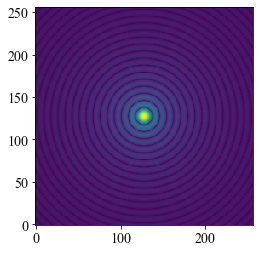

In [28]:
plt.imshow(psf**0.25)

In [29]:
dummy = np.array(mode.split(PPSZ))
dummy = np.array(dummy.split(PPSZ,axis=2))

subarray = dummy[0,0,:,:]
matrix, xx, yy, A = lsq_params(subarray)
vmap_mask = jit(vmap(jit_area,in_axes=(0)))

@jit
def binary_mask(coefficients):
    mode = make_mode(coefficients)
    dummy = np.array(mode.split(PPSZ))
    dummy = np.array(dummy.split(PPSZ,axis=2))
    flat = dummy.reshape(PPSZ*PPSZ,3,3)
    return vmap_mask(flat).reshape(PPSZ,PPSZ)

In [30]:
%%timeit
binary_mask(coefficients)

143 µs ± 28 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [31]:
# circle = morphine.CircularAperture(radius=pdiam/2,pad_factor=0)
# circle.pupil_diam = pdiam
circle = morphine.zernike.zernike_basis(1,npix=PPSZ,outside=0.0)[0,:,:]

def osys_from_binary(coefficients_sequence):
    
    binary = binary_mask(coefficients_sequence)

    aberrated = morphine.OpticalSystem(npix=PPSZ)
    aberrated.pupil_diameter = pdiam

    binary_pupil = morphine.ArrayOpticalElement(opd=binary*WAVELENGTH/2.,
                               transmission=np.abs(circle),
                               pixelscale=ppscale,
                               name='mask',planetype=1)
    
#     aberrated.add_pupil(circle)
    aberrated.add_pupil(binary_pupil)    # pupil radius in meters
    aberrated.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=2.*ISZ*PIXSCALE )
    return aberrated

def psf_from_binary(coefficients_sequence):
    aberrated = osys_from_binary(coefficients_sequence)
    blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')
    return blur.intensity,intermediate

In [32]:
opys = osys_from_binary(coefficients)

In [33]:
coefficients = onp.random.randn(NZ)
coefficients2 = onp.random.randn(NZ)


###  Now let's autodiff

In [34]:
psf,intermediate = psf_from_binary(coefficients)

In [35]:
jac_binary = jacfwd(binary_mask)

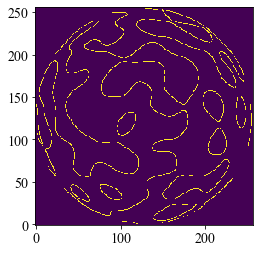

In [36]:
test = jac_binary(coefficients)
plt.imshow(test[:,:,5]!=0)

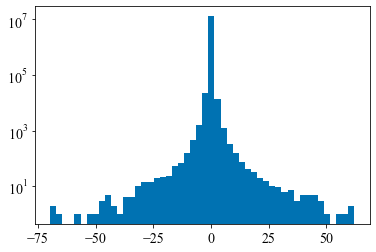

In [37]:
plt.hist(test.ravel(),bins=50);
plt.yscale('log')

### OK! So we can differentiate the making of a phase mask through the coefficients

In [38]:
# @jit
def objective_function_zernike(coefficients):
    psf = psf_from_zernikes(coefficients)
    return np.max(psf)

print(objective_function_zernike(coefficients))

grad_obj = (grad(objective_function_zernike))
print(grad_obj(coefficients))

2.2372274e-07
[-0.11811561  0.10288253  0.126551   -0.7451094   1.381624   -0.9946563
  0.5662765   0.33250737 -0.62988824 -0.7778896   0.54886335 -0.23842707
  0.07865686  0.14327389 -0.5594255   1.2212319   0.5652311  -1.0363643
  0.06488726  0.27813277 -0.16602506  0.78843504  0.0675228  -0.45926562
 -0.06773002  0.92739606  0.593046    1.0197085  -0.3237531  -0.53686595
 -0.5297094  -0.43724912  0.35791558 -0.8792279  -0.48507026  0.45468545
 -0.09709659  0.7639941  -0.04212481  0.47933218  0.02341071 -0.00689576
  0.14341937  0.08125774  0.24088094 -0.30299848  0.4650603  -0.89289534
 -0.2538044  -0.25668085  0.7742414   0.02499375  0.02704854  0.65910584
  0.7664806   0.64701116 -1.6229998   0.44369996  0.10551289  0.7726984
 -0.20677239 -0.551619    0.19042727  0.6755375   0.6793159   0.68119997
 -0.574634   -0.12671588  0.9843446  -0.49888137 -0.4018321  -0.05241446
  1.2911358   0.58825016 -0.17139731 -0.232121   -0.14491437 -0.8124244
 -0.23681886 -0.15637292  0.48528278 -0.4

In [39]:
from jax.config import config
config.update("jax_debug_nans", True)

In [40]:
# @jit
def objective_function_binary(coefficients_sequence):
    psf,intermediate = psf_from_binary(coefficients_sequence)
    return np.max(psf)

print(objective_function_binary(coefficients))

grad_obj = (grad(objective_function_binary)) # this won't jit because of normalization? why?
print(grad_obj(coefficients))

0.00024625118
[-1.87748719e-05 -9.75365856e-06  1.92649695e-05  2.49852947e-05
  9.55792621e-06 -1.15617122e-05 -4.58419981e-06  1.30923318e-05
  1.25231827e-05  1.32378746e-05 -1.41950786e-05  4.81991856e-06
 -1.61931039e-05  5.16159434e-06  6.58684576e-06  1.40245929e-05
 -1.04581686e-05 -3.67629082e-06  1.96216934e-06 -6.51185655e-06
 -8.08913319e-06 -1.08187869e-05  7.61570800e-06  9.18091155e-06
 -5.15579723e-06  7.13068539e-06 -4.17383774e-07  9.73848546e-06
  8.74253328e-06 -1.57783597e-05 -5.55624729e-06 -2.95091031e-05
  1.48623330e-05 -1.52288239e-05  4.28491967e-06 -3.38551035e-06
  3.42229032e-06 -1.39728236e-05  7.99247027e-06 -1.44869955e-05
  7.17239345e-06 -3.11594958e-05  2.50895773e-05 -9.00486157e-06
 -8.06306980e-06 -1.43054767e-05 -1.09993889e-05 -1.78120922e-06
 -5.36437665e-06  4.02971491e-05 -1.77598099e-06  8.51413824e-06
  2.36742508e-05 -1.08108297e-05  1.17358841e-05  6.50096854e-06
 -2.59522540e-06  1.70154999e-05 -3.16268597e-05  3.72890077e-06
 -1.5834653

In [41]:
%%timeit
grad_obj(coefficients)

517 ms ± 39.6 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [42]:
# factors = np.linspace(0.01,100,100)
# objs = []
# for factor in tqdm(factors):
#     test_coef = onp.copy(coefficients)
#     test_coef[5] *= factor
#     test_coef[15] /= factor
#     objs.append(objective_function_binary(test_coef))
# objs = np.array(objs)
# plt.plot(factors,objs)

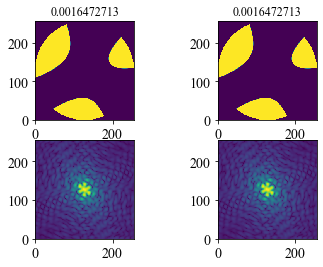

In [43]:
factors = [0.1,2]
objs = []
coefficients=  onp.random.randn(NZ)
fig, axes = plt.subplots(2,2)
for j, factor in enumerate(factors):
    test_coef = onp.copy(coefficients)
#     test_coef[3:] *= factor
    test_coef[10:] /= 1e5
    mask = binary_mask(test_coef)
    psf,intermediate = psf_from_binary(test_coef)
    axes[0,j].imshow(mask)
    axes[0,j].set_title(objective_function_binary(test_coef))
    
    axes[1,j].imshow(psf**0.25)


### Now for gradient descent!

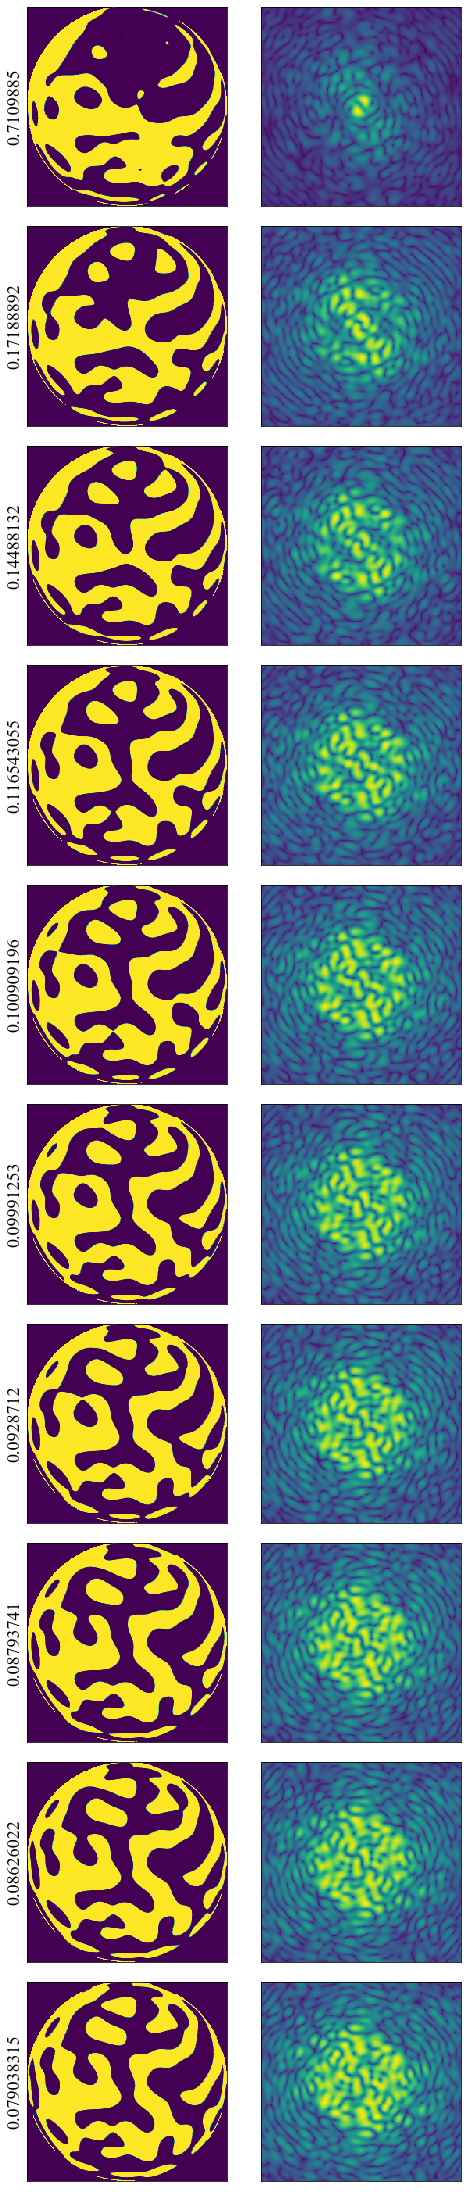

In [44]:
nstages = 10
fig, axes = plt.subplots(nstages,2,figsize=(8,nstages*4))
for ax in axes.ravel():
    ax.set_xticks([])
    ax.set_yticks([])
plt.subplots_adjust(wspace=0.1,hspace=0.1)

coefficients = onp.random.randn(NZ)
coefficients[10:] /= 1e5
norm = objective_function_binary(coefficients)

objs = []
k = 0
for j in tqdm(range(nstages*10)):
    coefficients -= 1e3*grad_obj(coefficients)
    obj = objective_function_binary(coefficients)
    objs.append(obj)
    if j%10 == 0:
        mask = binary_mask(coefficients)
        psf,intermediate = psf_from_binary(coefficients)
        axes[k,0].imshow(mask)
        axes[k,1].imshow(psf**0.25)
        axes[k,0].set_ylabel(obj/norm)
        k+=1
objs = np.array(objs)

Text(0.5, 0, 'Epoch')

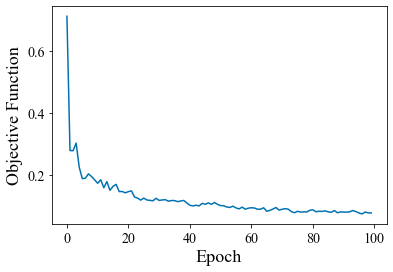

In [45]:
plt.plot(objs/norm)
plt.ylabel('Objective Function')
plt.xlabel('Epoch')

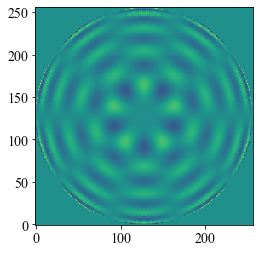

In [46]:
plt.imshow(morphine.zernike.zernike(21,-5,npix=PPSZ,outside=0.0))

In [47]:
# %%time
all_fivefold = []
for j in tqdm(range(10)):
    order=2*j+7
    up = np.floor(order/5).astype('int')
    for k in range(up):
        if ((k+1)*5 % 10) == 0.:
            continue
        all_fivefold.append(morphine.zernike.zernike(order,(k+1)*5,npix=PSZ,outside=0.0))
        all_fivefold.append(morphine.zernike.zernike(order,-(k+1)*5,npix=PSZ,outside=0.0))
all_fivefold = np.array(all_fivefold)
nfive = all_fivefold.shape[0]

In [48]:
@jit
def make_mode_fivefold(coeff):
    return np.dot(coeff,all_fivefold.reshape(nfive,PSZ*PSZ)).reshape(PSZ,PSZ)

@jit
def binary_mask_fivefold(coefficients):
    mode = make_mode_fivefold(coefficients)
    dummy = np.array(mode.split(PPSZ))
    dummy = np.array(dummy.split(PPSZ,axis=2))
    flat = dummy.reshape(PPSZ*PPSZ,3,3)
    return vmap_mask(flat).reshape(PPSZ,PPSZ)

circle = morphine.zernike.zernike_basis(1,npix=PPSZ,outside=0.0)[0,:,:]

def osys_fivefold(coefficients_sequence):
    
    binary = binary_mask_fivefold(coefficients_sequence)

    aberrated = morphine.OpticalSystem(npix=PPSZ)
    aberrated.pupil_diameter = pdiam

    binary_pupil = morphine.ArrayOpticalElement(opd=binary*WAVELENGTH/2.,
                               transmission=np.abs(circle),
                               pixelscale=ppscale,
                               name='mask',planetype=1)
    
#     aberrated.add_pupil(circle)
    aberrated.add_pupil(binary_pupil)    # pupil radius in meters
    aberrated.add_detector(pixelscale=PIXSCALE*2, fov_arcsec=2.*ISZ*PIXSCALE )
    return aberrated

def psf_fivefold(coefficients_sequence):
    aberrated = osys_fivefold(coefficients_sequence)
    blur,intermediate = aberrated.propagate_mono(WAVELENGTH,normalize='first')
    return blur.intensity,intermediate

In [49]:
coefficients = onp.random.randn(nfive)
opsys = osys_fivefold(coefficients)
psf,intermediate = psf_fivefold(coefficients)

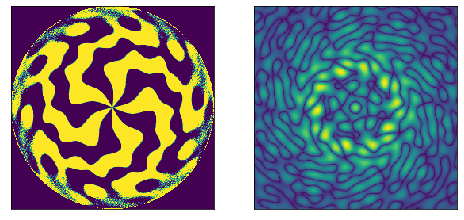

In [50]:
mask = binary_mask_fivefold(coefficients)
psf,intermediate = psf_fivefold(coefficients)

fig, (ax1,ax2) = plt.subplots(1,2,figsize=(8,4))

for ax in (ax1,ax2):
    ax.set_xticks([])
    ax.set_yticks([])
    
ax1.imshow(mask)
ax2.imshow(psf**0.25)